In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from timeseries_functions import index_to_datetime, plot_all_df_columns, weekly_resample, plot_series,\
plot_series_save_fig, plot_series_and_differences, run_augmented_Dickey_Fuller_test, \
plot_autocorrelation, plot_partial_autocorrelation, plot_decomposition

In [27]:
from timeseries_functions import make_col_vector, make_design_matrix, fit_linear_trend,\
plot_trend_data, plot_linear_trend

In [28]:
from AR_MA_functions import get_AR_model, plot_AR_model, get_AR_model_order_BIC,\
plot_BIC_AR_model, get_MA_model, plot_MA_model

In [29]:
from ARIMA_functions import get_ARIMA_model, plot_ARIMA_model, plot_ARIMA_resids,\
get_ARIMA_forecast, plot_ARIMA_forecast_and_CI, plot_data_plus_ARIMA_predictions, \
test_rolling_ARIMA_forecast,get_predictions_df_and_plot_rolling_ARIMA_forecast

In [30]:
from ARIMA_functions import get_ARIMAX_model, plot_ARIMAX_model, plot_ARIMAX_model_save_fig, \
plot_data_plus_ARIMAX_predictions, get_ARIMAX_predictions, get_ARIMAX_training_MSE,\
get_ARIMAX_train_test_predictions, get_ARIMAX_train_test_MSE

#### import data

In [31]:
# import weekly hours and numbers data
dr = pd.read_csv('./data/doctors_hours_per_provider.csv', index_col=0)
RNPA = pd.read_csv('./data/RNPA_hours_per_provider.csv',  index_col=0)
therapist = pd.read_csv('./data/therapists_hours_per_provider.csv',  index_col=0)

In [32]:
# number of providers
num_dr = dr['Number_Providers']
num_RNPA = RNPA['Number_Providers']
num_therapist = therapist['Number_Providers']

In [33]:
# provider hours
dr_hours = dr['Hours']
RNPA_hours = RNPA['Hours']
therapist_hours = therapist['Hours']

In [34]:
providers = [num_dr, num_RNPA, num_therapist]
hours = [dr_hours, RNPA_hours, therapist_hours]

In [35]:
# dr_hours.index
num_dr.index

Index(['2015-01-12', '2015-01-19', '2015-01-26', '2015-02-02', '2015-02-09',
       '2015-02-16', '2015-02-23', '2015-03-02', '2015-03-09', '2015-03-16',
       ...
       '2018-02-26', '2018-03-05', '2018-03-12', '2018-03-19', '2018-03-26',
       '2018-04-02', '2018-04-09', '2018-04-16', '2018-04-23', '2018-04-30'],
      dtype='object', name='AppointmentDate', length=173)

#### convert index to datetime 

In [36]:
for p in providers:
    p.index = pd.to_datetime(p.index)
for h in hours:
    h.index = pd.to_datetime(h.index)

In [37]:
dr_hours.head()

AppointmentDate
2015-01-12    84.25
2015-01-19    91.25
2015-01-26    82.00
2015-02-02    72.25
2015-02-09    97.25
Name: Hours, dtype: float64

In [38]:
# label each series for labeling plots
num_dr.name = 'Number of Doctors'
num_RNPA.name = 'Number of RN/PAs'
num_therapist.name = 'Number of Therapists'

In [39]:
dr_hours.name = 'Doctors Hours'
RNPA_hours.name = 'RN/PAs Hours'
therapist_hours.name = 'Therapists Hours'

#### test for stationarity in all time series

In [40]:
providers = [num_dr, num_RNPA, num_therapist]
hours = [dr_hours, RNPA_hours, therapist_hours]

In [41]:
for p in providers:  
    print(p.name)
    run_augmented_Dickey_Fuller_test(series=p, num_diffs=2)

Number of Doctors
ADF Statistic: -0.22210617686559714
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for the series is: 0.935834808802605
ADF Statistic: -10.062709665196218
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for difference 1 is: 1.3205934622804431e-17
ADF Statistic: -6.432226640445463
Critical values:
1%: -3.471118535474365
5%: -2.8794405060097024
10%: -2.576313761526591
The p-value for difference 2 is: 1.686328384757272e-08
Number of RN/PAs
ADF Statistic: -0.2858218164455114
Critical values:
1%: -3.469648263987657
5%: -2.878798906308495
10%: -2.5759713094779593
The p-value for the series is: 0.9274885217885349
ADF Statistic: -11.372131563286946
Critical values:
1%: -3.469648263987657
5%: -2.878798906308495
10%: -2.5759713094779593
The p-value for difference 1 is: 8.925784342155933e-21
ADF Statistic: -4.328790542467453
Critical values:
1%: -3.472161410886292
5%: -2.

In [42]:
for h in hours:
    print(h.name)
    run_augmented_Dickey_Fuller_test(series=h, num_diffs=2)

Doctors Hours
ADF Statistic: -0.7577330097905544
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for the series is: 0.8312235926317735
ADF Statistic: -13.032794678072865
Critical values:
1%: -3.4698858990744115
5%: -2.8789026251889647
10%: -2.5760266680839004
The p-value for difference 1 is: 2.3261760845392414e-24
ADF Statistic: -4.936782287119396
Critical values:
1%: -3.4729792729247793
5%: -2.8802520918255534
10%: -2.5767469641683105
The p-value for difference 2 is: 2.955880847496221e-05
RN/PAs Hours
ADF Statistic: -1.3334919589536902
Critical values:
1%: -3.470126426071447
5%: -2.8790075987120027
10%: -2.5760826967621644
The p-value for the series is: 0.6137138660917639
ADF Statistic: -9.423667716324665
Critical values:
1%: -3.470126426071447
5%: -2.8790075987120027
10%: -2.5760826967621644
The p-value for difference 1 is: 5.418320862866177e-16
ADF Statistic: -5.761340950482132
Critical values:
1%: -3.47086589632514
5%: -2.879330

In [43]:
providers[0].diff().isnull().sum()

1

#### determine number of AR and MA terms to add for each time series

In [44]:
hours[2].isnull().sum()

0

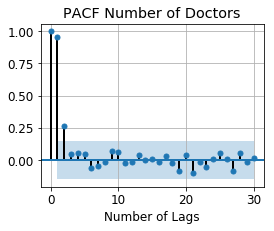

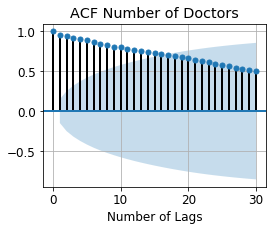

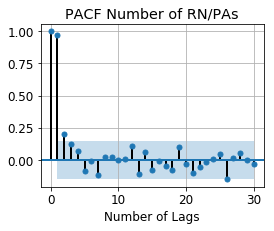

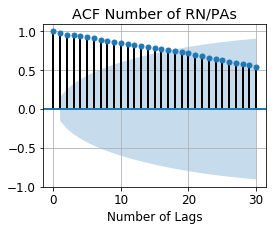

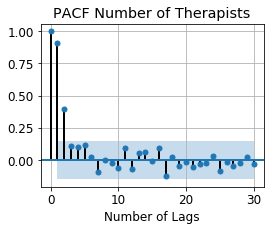

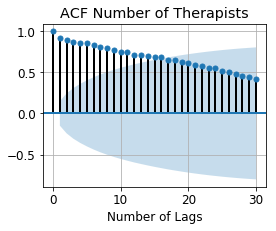

In [45]:
# Plot ACF and PACF of each series
for p in providers:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=p, params=params, lags=30, alpha=0.05, title='PACF {}'.format(p.name))
    plot_autocorrelation(series=p, params=params, lags=30, alpha=0.05, title='ACF {}'.format(p.name))

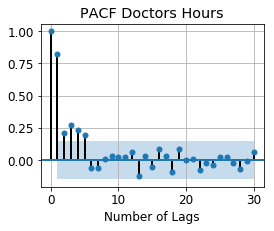

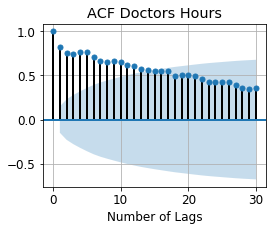

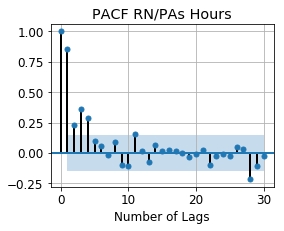

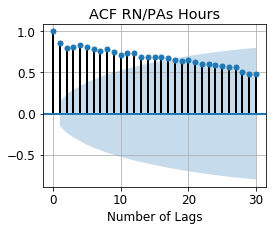

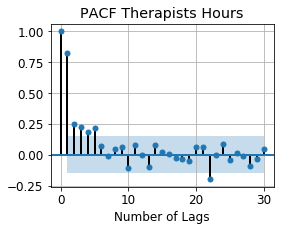

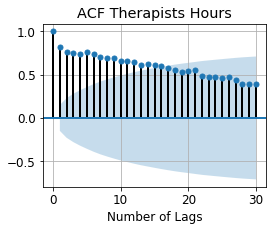

In [46]:
# Plot ACF and PACF of each series
for h in hours:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=h, params=params, lags=30, alpha=0.05, title='PACF {}'.format(h.name))
    plot_autocorrelation(series=h, params=params, lags=30, alpha=0.05, title='ACF {}'.format(h.name))

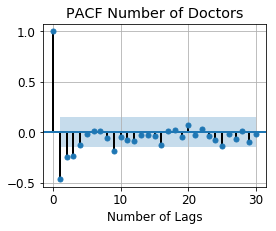

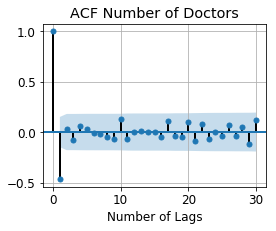

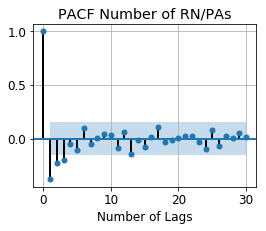

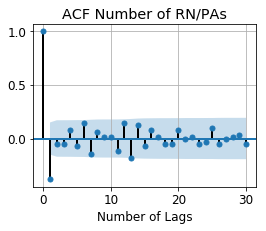

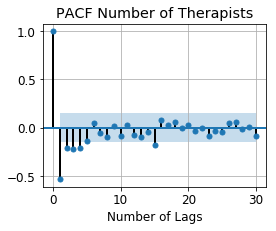

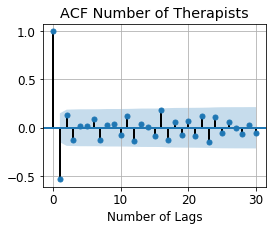

In [47]:
# Plot ACF and PACF of first difference of each series
for p in providers:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=p.diff()[1:], params=params, lags=30, alpha=0.05, title='PACF {}'.format(p.name))
    plot_autocorrelation(series=p.diff()[1:], params=params, lags=30, alpha=0.05, title='ACF {}'.format(p.name))

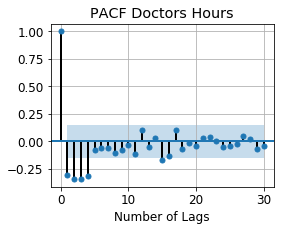

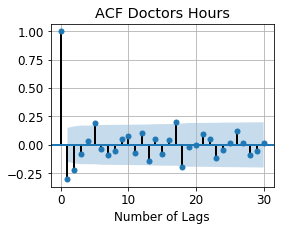

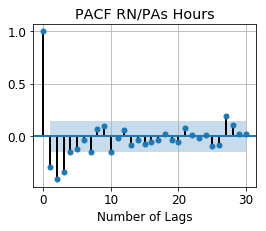

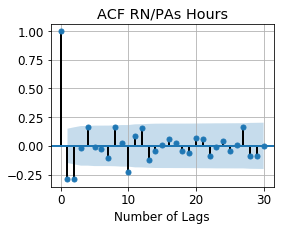

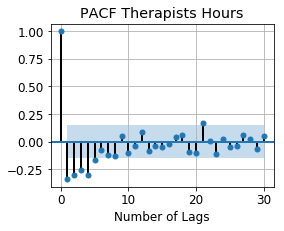

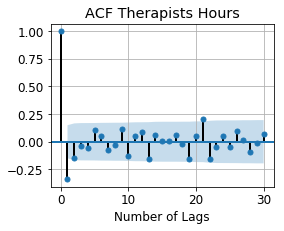

In [48]:
# Plot ACF and PACF of first difference of each series
for h in hours:
    params = {'figure.figsize': [4,3],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
    plot_partial_autocorrelation(series=h.diff()[1:], params=params, lags=30, alpha=0.05, title='PACF {}'.format(h.name))
    plot_autocorrelation(series=h.diff()[1:], params=params, lags=30, alpha=0.05, title='ACF {}'.format(h.name))

#### get ARIMAX model using num_provider as exogenous variable and plot

In [49]:
def get_ARIMAX_model(data, order, exog_var):
    """Fits ARIMAX model
    data: pandas Series
    order: (p,d,q) format
    exog_var = exogenous variable as pandas Series
    """
    arima = ARIMA(endog=data, order=order, exog=exog_var)
    results = arima.fit()
    summary = results.summary()
    params = results.params
    residuals = results.resid
    return results, summary, params, residuals

#### split data into training and test sets

In [50]:
train_start = '2015-01-12'
train_end = '2018-03-01'
test_start = '2018-03-01'

In [51]:
dr_train = dr.loc[train_start:train_end]
dr_test = dr.loc[test_start:]

In [52]:
# dr_train.tail()
dr_test.tail()

,Number_Providers,Hours,Hours_per_Provider
AppointmentDate,,,
2018-04-02,16.0,313.250000,19.578125
2018-04-09,17.0,332.916667,19.583333
2018-04-16,17.0,284.750000,16.750000
2018-04-23,17.0,297.833333,17.519608
2018-04-30,16.0,299.416667,18.713542


In [53]:
RNPA_train = RNPA.loc[train_start:train_end]
RNPA_test = RNPA.loc[test_start:]

In [54]:
ther_train = therapist.loc[train_start:train_end]
ther_test = therapist.loc[test_start:]

#### get MSE (train and test data) for each category, testing # of MA components to compare models

In [ ]:
# dr AR(4)MA(1)
# RN/PA AR(3)MA(2)
# ther AR(5)MA(1)

In [55]:
train_dfs = [dr_train, RNPA_train, ther_train]
test_dfs = [dr_test, RNPA_test, ther_test]
orders = [(4,1,1), (3,1,2), (5,1,1)]
endog_col = 'Hours'
exog_col = 'Number_Providers'
names = ['Doctors', 'RN/PAs', 'Therapists']
test_start='2018-03-05'
train_start = '2015-01-12'
train_end = '2018-02-26'

In [57]:
# get train/test predictions and MSE for all 3 categories 
train_mse = []
test_mse = []
category = []

for i in range(len(train_dfs)):
    forecast, full_df = get_ARIMAX_train_test_predictions(training_data=train_dfs[i][endog_col],\
            test_data=test_dfs[i][endog_col], order=orders[i], start='2015-01-19',\
            end='2018-04-30', exog=train_dfs[i][exog_col], typ='levels')
    train_error, test_error = get_ARIMAX_train_test_MSE(full_df, data_col='data', pred_col='forecast',\
                        train_end='2018-02-26', test_start='2018-03-05', data_name=names[i])   
    train_mse.append('training set: {}'.format(train_error))
    test_mse.append('test set: {}'.format(test_error))
    category.append('{} MSE'.format(names[i]))
mse = zip(train_mse, test_mse)
print(list(zip(category,mse)))

[('Doctors MSE', ('training set: 1005.8112231830528', 'test set: 784.6751134118571')), ('RN/PAs MSE', ('training set: 149.71532917537328', 'test set: 194.1696355084507')), ('Therapists MSE', ('training set: 105.80806435978357', 'test set: 35.63718570403454'))]


In [ ]:
# get train/test predictions and MSE for all 3 categories for MA=1
orders = [(5,1,1), (4,1,1), (5,1,1)]

train_mse = []
test_mse = []
category = []

for i in range(len(train_dfs)):
    forecast, full_df = get_ARIMAX_train_test_predictions(training_data=train_dfs[i][endog_col],\
            test_data=test_dfs[i][endog_col], order=orders[i], start='2015-01-19',\
            end='2018-04-30', exog=train_dfs[i][exog_col], typ='levels')
    train_error, test_error = get_ARIMAX_train_test_MSE(full_df, data_col='data', pred_col='forecast',\
                        train_end='2018-02-26', test_start='2018-03-05', data_name=names[i])   
    train_mse.append('training set: {}'.format(train_error))
    test_mse.append('test set: {}'.format(test_error))
    category.append('{} MSE'.format(names[i]))
mse = zip(train_mse, test_mse)
print(list(zip(category,mse)))

In [ ]:
# get train/test predictions and MSE for all 3 categories for MA=2
orders = [(5,1,2), (4,1,2), (5,1,2)]

train_mse = []
test_mse = []
category = []

for i in range(len(train_dfs)):
    forecast, full_df = get_ARIMAX_train_test_predictions(training_data=train_dfs[i][endog_col],\
            test_data=test_dfs[i][endog_col], order=orders[i], start='2015-01-19',\
            end='2018-04-30', exog=train_dfs[i][exog_col], typ='levels')
    train_error, test_error = get_ARIMAX_train_test_MSE(full_df, data_col='data', pred_col='forecast',\
                        train_end='2018-02-26', test_start='2018-03-05', data_name=names[i])   
    train_mse.append('training set: {}'.format(train_error))
    test_mse.append('test set: {}'.format(test_error))
    category.append('{} MSE'.format(names[i]))
mse = zip(train_mse, test_mse)
print(list(zip(category,mse)))

In [ ]:
# get train/test predictions and MSE for all 3 categories for MA=3
orders = [(5,1,3), (4,1,3), (5,1,3)]

train_mse = []
test_mse = []
category = []

for i in range(len(train_dfs)):
    forecast, full_df = get_ARIMAX_train_test_predictions(training_data=train_dfs[i][endog_col],\
            test_data=test_dfs[i][endog_col], order=orders[i], start='2015-01-19',\
            end='2018-04-30', exog=train_dfs[i][exog_col], typ='levels')
    train_error, test_error = get_ARIMAX_train_test_MSE(full_df, data_col='data', pred_col='forecast',\
                        train_end='2018-02-26', test_start='2018-03-05', data_name=names[i])   
    train_mse.append('training set: {}'.format(train_error))
    test_mse.append('test set: {}'.format(test_error))
    category.append('{} MSE'.format(names[i]))
mse = zip(train_mse, test_mse)
print(list(zip(category,mse)))

#### Doctors

In [ ]:
start_date = '2015-01-19' # b/c first row of data was differenced away
end_date = '2018-04-30'
end_pred = '2018-09-30'

In [ ]:
dr_results, dr_summary, dr_params, dr_residuals = get_ARIMAX_model(data=dr_hours,\
                    exog_var=num_dr, order=(5,1,0))

In [ ]:
num_dr

In [ ]:
def plot_ARIMAX_model_save_fig(data, order, exog_var, start, end, title='', xlabel='', ylabel='',
                              figname='figure.png'):
    """Plots ARIMAX model
    data: pandas Series
    order: (p,d,q) format
    exog_var = exogenous variable as pandas Series
    start/end: starting/ending dates for plot (x_axis)
    """
    results = ARIMA(endog=data, order=order, exog=exog_var).fit()
    fig = results.plot_predict(start=start, end=end,exog=exog_var)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    fig.savefig(figname)

In [ ]:
# plot and save doctors figure using 2 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

plot_ARIMAX_model_save_fig(data=dr_hours, order=(5,1,0), exog_var=num_dr, start=start_date,\
                end=end_pred, title='Doctors AR5/MA0', xlabel='Time', ylabel='Appointment Hours',
                              figname='./images/dr_AR[5]IMA[0]X.png')

In [ ]:
# using 5 AR components loop through and plot/test 0-3 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

for i in range(1,4):
    fig = plot_ARIMAX_model(data=dr_hours, order=(5,1,i), exog_var=num_dr, start=start_date,\
                         end=end_pred, title='AR5/MA{i}'.format(i=i))

In [ ]:
def get_ARIMAX_predictions(data, order, start, end, exog=None, typ='levels'):
    """Get ARIMAX predictions
    Inputs:
        data: pandas Series
        order: (p,d,q) format
        start/end: (str) starting/ending dates
        exog: data for exogenous variable as pandas series
    Outputs:
        data_plus_forecast: dataframe with original data and forecast plot_all_df_columns
        forecast: just predictions
    """
    data = data.to_frame()
    results = ARIMA(data, order=order, exog=exog).fit()
    forecast = results.predict(start=start, end=end, exog=exog, typ=typ).to_frame()
    data_plus_forecast = pd.merge(left=data, right=forecast, how='outer', left_index=True, right_index=True)
    data_plus_forecast.columns = ['data', 'forecast']
    return forecast, data_plus_forecast

In [ ]:
# getARIMAX predictions and data+predictions dataframe for doctors using order = (5,1,0)

start_date = '2015-01-19'
end_pred = '2018-09-30'
dr_forecast, dr_data_plus_forecast = get_ARIMAX_predictions(data=dr_hours, order=(5,1,0), start=start_date,\
                    end=end_pred, exog=num_dr, typ='levels')

In [ ]:
dr_forecast

In [ ]:
# for order = (5,1,0)
dr_forecast

In [ ]:
dr_data_plus_forecast.columns

In [ ]:
# rename columns in forecast df
dr_data_plus_forecast.columns = ['Appointment_Hours', 'Predicted_Hours']

In [ ]:
dr_data_plus_forecast

In [ ]:
# Round Appointment Hours and Predicted Hours values
dr_data_plus_forecast['Appointment_Hours'] = round(dr_data_plus_forecast['Appointment_Hours'], 2)
dr_data_plus_forecast['Predicted_Hours'] = round(dr_data_plus_forecast['Predicted_Hours'], 2)

In [ ]:
# add number of providers column
dr_data_plus_forecast['Number_Providers'] = num_dr

In [ ]:
# calculate hours per provider
dr_data_plus_forecast['Hours_per_Provider'] = round(dr_data_plus_forecast['Appointment_Hours'] / dr_data_plus_forecast['Number_Providers'],2)

In [ ]:
# calculate predicted number of providers and hours/provider columns
dr_data_plus_forecast['Pred_Hours_per_Provider'] = round(dr_data_plus_forecast['Predicted_Hours']/dr_data_plus_forecast['Number_Providers'], 2)

In [ ]:
dr_data_plus_forecast

In [ ]:
avg_dr_hours = dr_data_plus_forecast['Hours_per_Provider'].mean()

In [ ]:
avg_dr_hours

In [ ]:
# get predicted number of providers, rounded 
dr_data_plus_forecast['Predicted_Num_Providers'] = round(dr_data_plus_forecast['Predicted_Hours'] / avg_dr_hours, 1)

In [ ]:
dr_data_plus_forecast

In [ ]:
# output full forecast dataframe to csv
dr_data_plus_forecast.to_csv('./data/dr_arimax_forecast.csv')

In [ ]:
# get 12 week forecast
dr_12wk_arimax = dr_data_plus_forecast['2018-05-07':'2018-07-30'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
dr_12wk_arimax.index = dr_12wk_arimax.index.date

In [ ]:
# get 8-16 week forecast
dr_8_to_16wk_arimax = dr_data_plus_forecast['2018-06-25':'2018-08-26'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
dr_8_to_16wk_arimax.index = dr_8_to_16wk_arimax.index.date

In [ ]:
dr_8_to_16wk_arimax

In [ ]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, dr_8_to_16wk_arimax, loc='center', colWidths=[0.3]*len(dr_8_to_16wk_arimax.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(20)
tabla.scale(1.5, 2) 
plt.savefig('./images/dr_8_to_16wk_arimax.png', transparent=True)

In [ ]:
dr_12wk_arimax

In [ ]:
# plot acf/pacf of Dr ARIMAX residuals
params = {'figure.figsize': [4,4],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plot_partial_autocorrelation(series=dr_residuals, params=params, lags=30, alpha=0.05, title='PACF {}'.format('Dr ARIMAX residuals'))
plot_autocorrelation(series=dr_residuals, params=params, lags=30, alpha=0.05, title='ACF {}'.format('Dr ARIMAX residuals'))

#### RN/PAs

In [ ]:
start_date = '2015-01-19' # b/c first row was differenced away
end_date = '2018-04-30'
end_pred = '2018-09-30'
RNPA_order = (4,1,4)

In [ ]:
RNPA_results, RNPA_summary, RNPA_params, RNPA_residuals = get_ARIMAX_model(data=dr_hours,\
                    exog_var=num_dr, order=RNPA_order)

In [ ]:
# plot and save RN/PA figure 
# using 4 AR components and 3 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

plot_ARIMAX_model_save_fig(data=RNPA_hours, order=(4,1,3), exog_var=num_RNPA, start=start_date,\
                end=end_pred, title='RN/PAs', xlabel='Time', ylabel='Appointment Hours',
                              figname='./images/RNPA_ARIMAX.png')

In [ ]:
# using 4 AR components plot/test with 0-2 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

for i in range(3):
    fig = plot_ARIMAX_model(data=RNPA_hours, order=(4,1,i), exog_var=num_RNPA, start=start_date,\
                         end=end_pred, title='AR4/MA{i}'.format(i=i))

In [ ]:
# getARIMAX predictions and data+predictions dataframe for RN/PAs order=(4,1,0)
start_date = '2015-01-19'
end_pred = '2018-09-30'
RNPA_forecast, RNPA_data_plus_forecast = get_ARIMAX_predictions(data=RNPA_hours, order=(4,1,3), start=start_date,\
                    end=end_pred, exog=num_RNPA, typ='levels')

In [ ]:
RNPA_forecast

In [ ]:
# rename columns in forecast df
RNPA_data_plus_forecast.columns = ['Appointment_Hours', 'Predicted_Hours']

# Round Predicted Hours values
RNPA_data_plus_forecast['Predicted_Hours'] = round(RNPA_data_plus_forecast['Predicted_Hours'], 2)

# add number of providers and hours/provider columns
RNPA_data_plus_forecast['Number_Providers'] = num_RNPA
RNPA_data_plus_forecast['Pred_Hours_per_Provider'] = round(RNPA_data_plus_forecast['Predicted_Hours']/RNPA_data_plus_forecast['Number_Providers'], 2)

In [ ]:
avg_RNPA_hours = RNPA_data_plus_forecast['Pred_Hours_per_Provider'].mean()

In [ ]:
avg_RNPA_hours

In [ ]:
# get predicted number of providers rounded
RNPA_data_plus_forecast['Predicted_Num_Providers'] = round(RNPA_data_plus_forecast['Predicted_Hours'] / avg_RNPA_hours, 1)

In [ ]:
RNPA_data_plus_forecast

In [ ]:
# output full forecast dataframe to csv
RNPA_data_plus_forecast.to_csv('./data/RNPA_arimax_forecast.csv')

In [ ]:
# get 12 week forecast
RNPA_12wk_arimax = RNPA_data_plus_forecast['2018-05-07':'2018-07-30'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
RNPA_12wk_arimax.index = RNPA_12wk_arimax.index.date

In [ ]:
# get 8-16 week forecast
RNPA_8_to_16wk_arimax = RNPA_data_plus_forecast['2018-06-25':'2018-08-26'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
RNPA_8_to_16wk_arimax.index = RNPA_8_to_16wk_arimax.index.date

In [ ]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, RNPA_8_to_16wk_arimax, loc='center', colWidths=[0.25]*len(RNPA_8_to_16wk_arimax.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/RNPA_8_to_16wk_arimax.png', transparent=True)

In [ ]:
# plot acf/pacf of RN/PA ARIMAX residuals
params = {'figure.figsize': [4,4],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plot_partial_autocorrelation(series=RNPA_residuals, params=params, lags=30, alpha=0.05, title='PACF {}'.format('RN/PA ARIMAX residuals'))
plot_autocorrelation(series=RNPA_residuals, params=params, lags=30, alpha=0.05, title='ACF {}'.format('RN/PA ARIMAX residuals'))

#### therapists

In [ ]:
start_date = '2015-01-19' # b/c first row was differenced away 
end_date = '2018-04-30'
end_pred = '2018-09-30'
therapist_order = (5,1,3)

In [ ]:
therapist_results, therapist_summary, therapist_params, therapist_residuals = get_ARIMAX_model(data=therapist_hours,\
                    exog_var=num_therapist, order=therapist_order)

In [ ]:
# plot and save therapist figure 
# using 5 AR components and 3 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

plot_ARIMAX_model_save_fig(data=therapist_hours, order=(5,1,3), exog_var=num_therapist, start=start_date,\
                end=end_pred, title='Therapists AR5/MA3', xlabel='Time', ylabel='Appointment Hours',
                              figname='./images/therapist_ARIMAX.png')

In [ ]:
# using 5 AR components plot/test with 0-2 MA components
params = {'figure.figsize': [12,6],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plt.rcParams.update(params)

for i in range(3):
    fig = plot_ARIMAX_model(data=therapist_hours, order=(5,1,i), exog_var=num_therapist, start=start_date,\
                         end=end_pred, title='Therapists AR4/MA{i}'.format(i=i))

In [ ]:
# getARIMAX predictions and data+predictions dataframe for therapists
start_date = '2015-01-19'
end_pred = '2018-09-30'
ther_forecast, ther_data_plus_forecast = get_ARIMAX_predictions(data=therapist_hours, order=(5,1,3), start=start_date,\
                    end=end_pred, exog=num_therapist, typ='levels')

In [ ]:
# rename columns in forecast df
ther_data_plus_forecast.columns = ['Appointment_Hours', 'Predicted_Hours']

# Round Predicted Hours values
ther_data_plus_forecast['Predicted_Hours'] = round(ther_data_plus_forecast['Predicted_Hours'], 2)

# add number of providers and hours/provider columns
ther_data_plus_forecast['Number_Providers'] = num_therapist
ther_data_plus_forecast['Pred_Hours_per_Provider'] = round(ther_data_plus_forecast['Predicted_Hours']/ther_data_plus_forecast['Number_Providers'], 1)

In [ ]:
avg_ther_hours = ther_data_plus_forecast['Pred_Hours_per_Provider'].mean()

In [ ]:
avg_ther_hours

In [ ]:
# get predicted number of providers rounded up
ther_data_plus_forecast['Predicted_Num_Providers'] = round(ther_data_plus_forecast['Predicted_Hours'] / avg_ther_hours, 1)

In [ ]:
ther_data_plus_forecast

In [ ]:
# output full forecast dataframe to csv
ther_data_plus_forecast.to_csv('./data/therapist_arimax_forecast.csv')

In [ ]:
# get 12 week forecast
ther_12wk_arimax = ther_data_plus_forecast['2018-05-07':'2018-07-30'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
ther_12wk_arimax.index = ther_12wk_arimax.index.date

In [ ]:
# get 8-16 week forecast
ther_8_to_16wk_arimax = ther_data_plus_forecast['2018-06-25':'2018-08-26'][['Predicted_Hours', 'Predicted_Num_Providers']]
# keep only date in index, drop time
ther_8_to_16wk_arimax.index = ther_8_to_16wk_arimax.index.date

In [ ]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, ther_8_to_16wk_arimax, loc='center', colWidths=[0.25]*len(ther_8_to_16wk_arimax.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/ther_8_to_16wk_arimax.png', transparent=True)

In [ ]:
# plot acf/pacf of therapist ARIMAX residuals
params = {'figure.figsize': [4,4],'axes.grid.axis': 'both', 'axes.grid': True, 'axes.labelsize': 'Medium', 'font.size': 12.0, \
'lines.linewidth': 2}
plot_partial_autocorrelation(series=therapist_residuals, params=params, lags=30, alpha=0.05, title='PACF {}'.format('Therapist ARIMAX residuals'))
plot_autocorrelation(series=therapist_residuals, params=params, lags=30, alpha=0.05, title='ACF {}'.format('Therapist ARIMAX residuals'))